# New York City Taxi Fare Prediction\n

This notebook provides a comprehensive solution for the Kaggle \"New York City Taxi Fare Prediction\" competition. It covers data download, exploratory data analysis (EDA), data cleaning and preprocessing, advanced feature engineering, model training with XGBoost and LightGBM, model evaluation, and submission file generation.

## 1. Kaggle API Setup and Data Download\n

To download the competition data directly into Google Colab, you need to set up your Kaggle API credentials. Follow these steps:\n
1. Go to your Kaggle account (kaggle.com/your_username/account).
2. Under the \"API\" section, click \"Create New API Token\". This will download a `kaggle.json` file.
3. Upload this `kaggle.json` file to your Google Colab environment. You can do this by clicking the folder icon on the left sidebar, then the \"Upload to session storage\" icon.
4. Run the following code cells to install the Kaggle API client and download the data.

In [1]:
!pip install kaggle

In [10]:
# Connect to Google Drive for loading kaggle.json
from google.colab import drive
drive.mount('/content/drive')

# Create a .kaggle directory and move the kaggle.json file into it
!mkdir -p ~/.kaggle
!mv /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Download the competition data
!kaggle competitions download -c new-york-city-taxi-fare-prediction

 98% 1.54G/1.56G [00:09<00:00, 259MB/s]
100% 1.56G/1.56G [00:09<00:00, 175MB/s]


In [13]:
# Unzip the downloaded data
!unzip new-york-city-taxi-fare-prediction.zip -d data

Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: data/GCP-Coupons-Instructions.rtf  
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


## 2. Data Loading and Subsampling

The training dataset is very large (approx. 55 million rows). For efficient processing in a free-tier Google Colab environment, we will subsample the training data. The test set is much smaller and will be loaded entirely.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
# Optional: import catboost as cb

# Load training data (subsampled)
CHUNK_SIZE = 500000  # Adjust as needed for Colab memory limits
N_ROWS = 5000000 # Number of rows to read from the training data

df_train = pd.read_csv('data/train.csv', nrows=N_ROWS, parse_dates=['pickup_datetime'])

# Load test data
df_test = pd.read_csv('data/test.csv', parse_dates=['pickup_datetime'])

print(f'Training data shape: {df_train.shape}')
print(f'Test data shape: {df_test.shape}')

Training data shape: (5000000, 8)
Test data shape: (9914, 7)


## 3. Exploratory Data Analysis (EDA)

Let's explore the dataset to understand its characteristics, distributions, and potential issues.

In [15]:
# Display basic information and descriptive statistics
print('Train Info:')
df_train.info()
print('\nTrain Description:')
df_train.describe()

print('\nTest Info:')
df_test.info()
print('\nTest Description:')
df_test.describe()

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 305.2+ MB

Train Description:

Test Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 n

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


### Fare Amount Distribution

Let's check the distribution of the target variable, `fare_amount`.

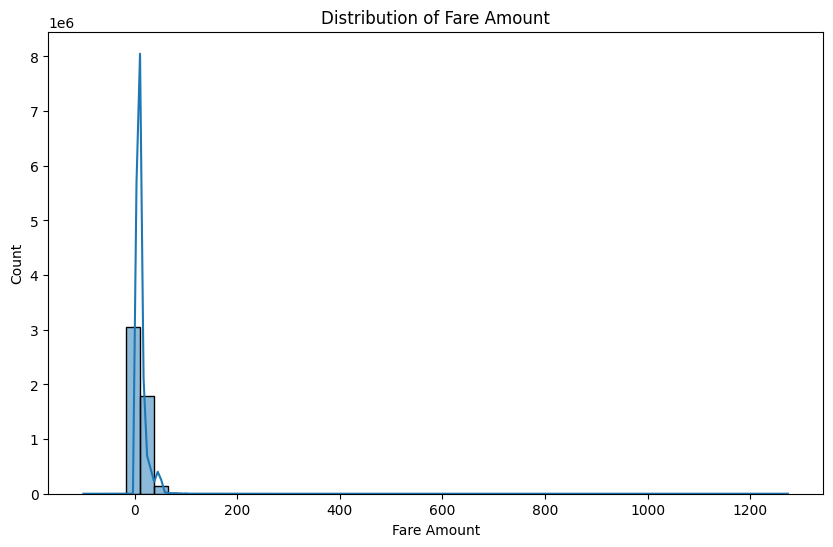

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Count')
plt.show()

### Passenger Count Distribution

Investigate the distribution of `passenger_count`.

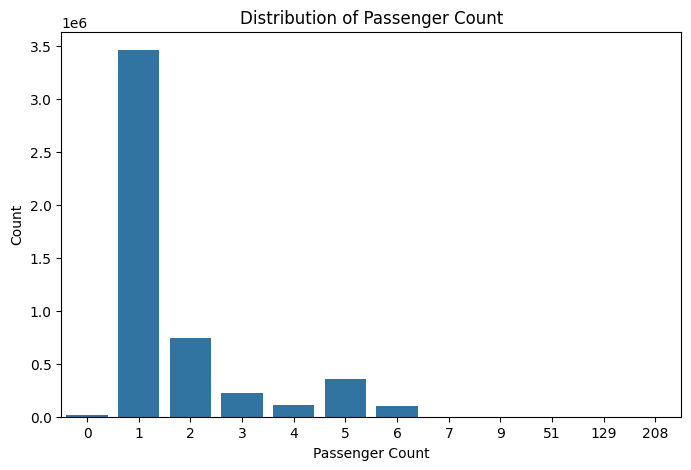

In [17]:
plt.figure(figsize=(8, 5))
sns.countplot(x='passenger_count', data=df_train)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.show()

### Geospatial Analysis

Visualize pickup and dropoff locations to identify common areas and potential outliers.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


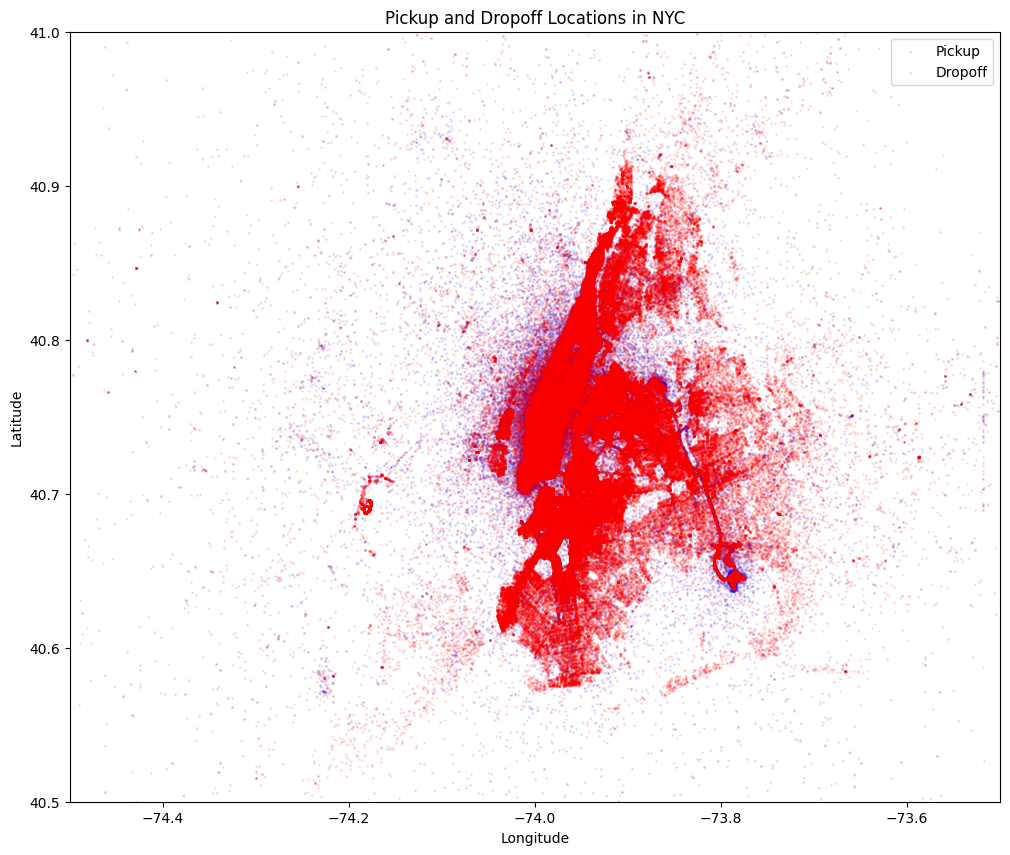

In [18]:
# Filter out extreme coordinates for better visualization
# NYC coordinates roughly: Latitude (40.5 to 40.9), Longitude (-74.2 to -73.7)
BBOX = (-74.5, -73.5, 40.5, 41.0) # min_lon, max_lon, min_lat, max_lat

df_train_filtered = df_train[
    (df_train['pickup_longitude'] > BBOX[0]) & (df_train['pickup_longitude'] < BBOX[1]) &
    (df_train['pickup_latitude'] > BBOX[2]) & (df_train['pickup_latitude'] < BBOX[3]) &
    (df_train['dropoff_longitude'] > BBOX[0]) & (df_train['dropoff_longitude'] < BBOX[1]) &
    (df_train['dropoff_latitude'] > BBOX[2]) & (df_train['dropoff_latitude'] < BBOX[3])
].copy()

plt.figure(figsize=(12, 10))
plt.scatter(df_train_filtered['pickup_longitude'], df_train_filtered['pickup_latitude'],
            color='blue', label='Pickup', alpha=0.1, s=1)
plt.scatter(df_train_filtered['dropoff_longitude'], df_train_filtered['dropoff_latitude'],
            color='red', label='Dropoff', alpha=0.1, s=1)
plt.title('Pickup and Dropoff Locations in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(BBOX[0], BBOX[1])
plt.ylim(BBOX[2], BBOX[3])
plt.legend()
plt.show()

### Time-based Analysis

Analyze `fare_amount` trends based on time of day, day of week, etc.

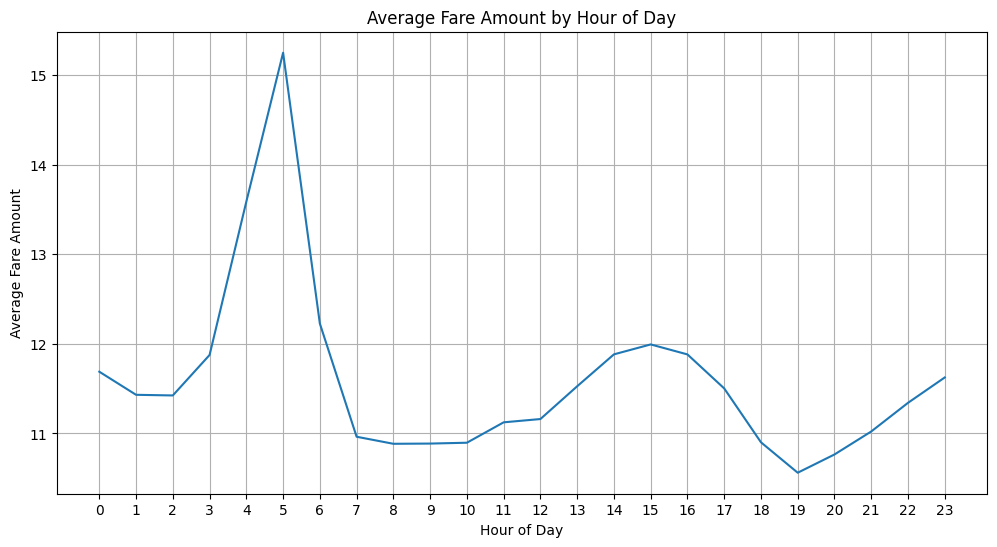

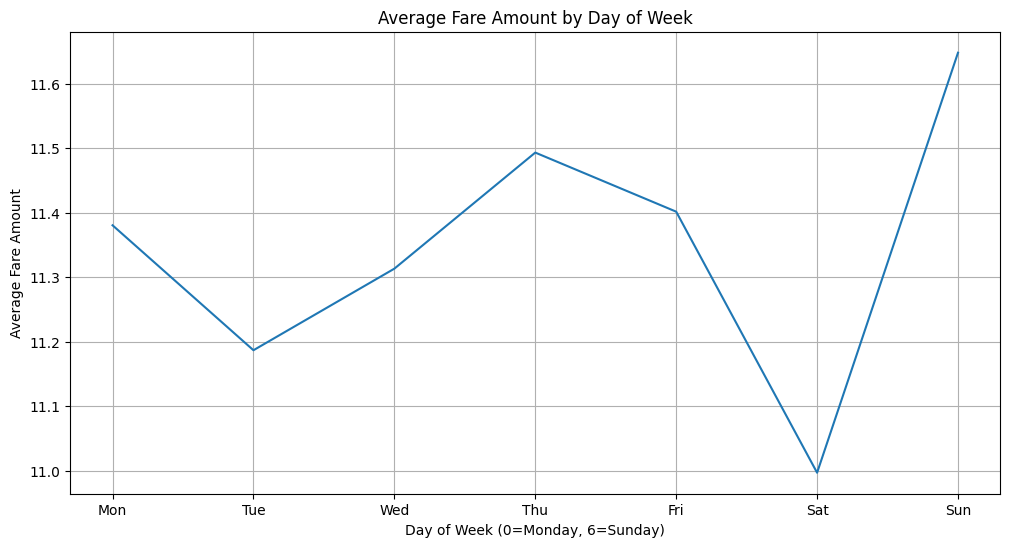

In [19]:
# Extract time features for EDA
df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['day_of_week'] = df_train['pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['year'] = df_train['pickup_datetime'].dt.year

plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='fare_amount', data=df_train.groupby('hour')['fare_amount'].mean().reset_index())
plt.title('Average Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount')
plt.xticks(range(24))
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x='day_of_week', y='fare_amount', data=df_train.groupby('day_of_week')['fare_amount'].mean().reset_index())
plt.title('Average Fare Amount by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Fare Amount')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

## 4. Data Cleaning and Preprocessing

Clean the data by handling missing values, outliers, and illogical entries.

In [20]:
# Handle missing values (if any)
print('Missing values in train data before cleaning:')
print(df_train.isnull().sum())
print('\nMissing values in test data before cleaning:')
print(df_test.isnull().sum())

# Drop rows with any missing values
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

print('\nMissing values in train data after cleaning:')
print(df_train.isnull().sum())
print('\nMissing values in test data after cleaning:')
print(df_test.isnull().sum())

Missing values in train data before cleaning:
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
hour                  0
day_of_week           0
month                 0
year                  0
dtype: int64

Missing values in test data before cleaning:
key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Missing values in train data after cleaning:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day_of_week          0
month                0
year                 0
dtype: int64

Missing values in test data after cleaning:
key                  0
pickup_datetime      0
pickup_

In [21]:
# Remove outliers and illogical values
# Fare amount: must be positive and reasonable
df_train = df_train[df_train['fare_amount'] > 0]
df_train = df_train[df_train['fare_amount'] < 500] # Upper bound for fare amount

# Passenger count: must be between 1 and 6 (typical taxi capacity)
df_train = df_train[df_train['passenger_count'] >= 1]
df_train = df_train[df_train['passenger_count'] <= 6]

# Coordinates: must be within reasonable NYC bounds
# Using the BBOX defined earlier
df_train = df_train[
    (df_train['pickup_longitude'] > BBOX[0]) & (df_train['pickup_longitude'] < BBOX[1]) &
    (df_train['pickup_latitude'] > BBOX[2]) & (df_train['pickup_latitude'] < BBOX[3]) &
    (df_train['dropoff_longitude'] > BBOX[0]) & (df_train['dropoff_longitude'] < BBOX[1]) &
    (df_train['dropoff_latitude'] > BBOX[2]) & (df_train['dropoff_latitude'] < BBOX[3])
]

print(f'Training data shape after cleaning: {df_train.shape}')

Training data shape after cleaning: (4873468, 12)


## 5. Advanced Feature Engineering

Create new features that can help the model better understand the underlying patterns in the data.

In [25]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def feature_engineer(df):
    # Time features
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
    df['month'] = df['pickup_datetime'].dt.month
    df['year'] = df['pickup_datetime'].dt.year
    df['day_of_year'] = df['pickup_datetime'].dt.dayofyear
    df['week_of_year'] = df['pickup_datetime'].dt.isocalendar().week.astype(int)

    # Haversine distance
    df['haversine_distance'] = haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )

    # Manhattan distance (L1 norm)
    df['manhattan_distance'] = np.abs(df['pickup_longitude'] - df['dropoff_longitude']) + \
                               np.abs(df['pickup_latitude'] - df['dropoff_latitude'])

    # Bearing (direction of travel)
    # This can be complex, for simplicity, we'll skip it for now or use a simplified version
    # For a more advanced solution, consider adding this.

    # Add features related to famous NYC landmarks/airports
    # JFK Airport coordinates: 40.6413° N, 73.7781° W
    # Newark Liberty International Airport (EWR): 40.6895° N, 74.1745° W
    # LaGuardia Airport (LGA): 40.7769° N, 73.8740° W
    # Midtown Manhattan (approx): 40.7580° N, 73.9855° W

    jfk_lat, jfk_lon = 40.6413, -73.7781
    ewr_lat, ewr_lon = 40.6895, -74.1745
    lga_lat, lga_lon = 40.7769, -73.8740
    mid_man_lat, mid_man_lon = 40.7580, -73.9855

    df['dist_to_jfk_pickup'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'], jfk_lat, jfk_lon)
    df['dist_to_jfk_dropoff'] = haversine_distance(df['dropoff_latitude'], df['dropoff_longitude'], jfk_lat, jfk_lon)
    df['dist_to_ewr_pickup'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'], ewr_lat, ewr_lon)
    df['dist_to_ewr_dropoff'] = haversine_distance(df['dropoff_latitude'], df['dropoff_longitude'], ewr_lat, ewr_lon)
    df['dist_to_lga_pickup'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'], lga_lat, lga_lon)
    df['dist_to_lga_dropoff'] = haversine_distance(df['dropoff_latitude'], df['dropoff_longitude'], lga_lat, lga_lon)
    df['dist_to_mid_man_pickup'] = haversine_distance(df['pickup_latitude'], df['pickup_longitude'], mid_man_lat, mid_man_lon)
    df['dist_to_mid_man_dropoff'] = haversine_distance(df['dropoff_latitude'], df['dropoff_longitude'], mid_man_lat, mid_man_lon)

    return df

df_train = feature_engineer(df_train)
df_test = feature_engineer(df_test)

print(f'Training data shape after feature engineering: {df_train.shape}')
print(f'Test data shape after feature engineering: {df_test.shape}')
print('\nTrain data with new features:')
print(df_train.head())

Training data shape after feature engineering: (4873468, 24)
Test data shape after feature engineering: (9914, 23)

Train data with new features:
                             key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.96809

## 6. Model Training and Evaluation

We will train XGBoost and LightGBM models, which are powerful gradient boosting frameworks known for their performance on tabular data. We will evaluate the models using RMSE.

In [26]:
# Define features (X) and target (y)
features = [col for col in df_train.columns if col not in ['key', 'pickup_datetime', 'fare_amount']]
X_train = df_train[features]
y_train = df_train['fare_amount']
X_test = df_test[features]

# Align columns - crucial if feature engineering creates different columns or order
# This ensures that both train and test sets have the same features in the same order
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

print(f'Features used for training: {features}')
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

Features used for training: ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'day_of_week', 'month', 'year', 'day_of_year', 'week_of_year', 'haversine_distance', 'manhattan_distance', 'dist_to_jfk_pickup', 'dist_to_jfk_dropoff', 'dist_to_ewr_pickup', 'dist_to_ewr_dropoff', 'dist_to_lga_pickup', 'dist_to_lga_dropoff', 'dist_to_mid_man_pickup', 'dist_to_mid_man_dropoff']
X_train shape: (4873468, 21)
X_test shape: (9914, 21)


### XGBoost Model

Train an XGBoost Regressor.

In [28]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Objective for regression tasks
    n_estimators=1000,             # Number of boosting rounds
    learning_rate=0.05,            # Step size shrinkage
    max_depth=7,                   # Maximum depth of a tree
    subsample=0.8,                 # Subsample ratio of the training instance
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    random_state=42,               # Random seed for reproducibility
    n_jobs=-1                      # Use all available CPU cores
)

print('Training XGBoost model...')
xgb_model.fit(X_train, y_train)
print('XGBoost training complete.')

xgb_predictions = xgb_model.predict(X_train)
xgb_rmse = np.sqrt(mean_squared_error(y_train, xgb_predictions))
print(f'XGBoost RMSE on training data: {xgb_rmse:.4f}')

Training XGBoost model...
XGBoost training complete.
XGBoost RMSE on training data: 3.1827


### LightGBM Model

Train a LightGBM Regressor.

In [29]:
lgb_model = lgb.LGBMRegressor(
    objective='regression',        # Objective for regression tasks
    n_estimators=1000,             # Number of boosting rounds
    learning_rate=0.05,            # Step size shrinkage
    num_leaves=64,                 # Max number of leaves in one tree
    max_depth=-1,                  # No limit on tree depth
    min_child_samples=20,          # Minimum number of data needed in a child (leaf)
    subsample=0.8,                 # Subsample ratio of the training instance
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    random_state=42,               # Random seed for reproducibility
    n_jobs=-1                      # Use all available CPU cores
)

print('Training LightGBM model...')
lgb_model.fit(X_train, y_train)
print('LightGBM training complete.')

lgb_predictions = lgb_model.predict(X_train)
lgb_rmse = np.sqrt(mean_squared_error(y_train, lgb_predictions))
print(f'LightGBM RMSE on training data: {lgb_rmse:.4f}')

Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.189809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 4873468, number of used features: 21
[LightGBM] [Info] Start training from score 11.313150
LightGBM training complete.
LightGBM RMSE on training data: 3.2438


## 7. Prediction and Submission

Generate predictions on the test set and create the `submission.csv` file.

In [31]:
# Predict on the test set using the better performing model (or an ensemble)
# For simplicity, let's use LightGBM predictions for now.
# In a real scenario, you might average predictions from both models or use a stacking approach.
test_predictions = xgb_model.predict(X_test)

# Ensure predictions are non-negative
test_predictions[test_predictions < 0] = 0

# Create submission DataFrame
submission = pd.DataFrame({
    'key': df_test['key'],
    'fare_amount': test_predictions
})

# Save submission file
submission.to_csv('xgb_submission.csv', index=False)

print('Submission file created successfully: submission.csv')
print(submission.head())

Submission file created successfully: submission.csv
                           key  fare_amount
0  2015-01-27 13:08:24.0000002    10.702604
1  2015-01-27 13:08:24.0000003    11.430605
2  2011-10-08 11:53:44.0000002     4.359190
3  2012-12-01 21:12:12.0000002     8.970712
4  2012-12-01 21:12:12.0000003    16.562660


In [30]:
# Predict on the test set using the better performing model (or an ensemble)
# For simplicity, let's use LightGBM predictions for now.
# In a real scenario, you might average predictions from both models or use a stacking approach.
test_predictions = lgb_model.predict(X_test)

# Ensure predictions are non-negative
test_predictions[test_predictions < 0] = 0

# Create submission DataFrame
submission = pd.DataFrame({
    'key': df_test['key'],
    'fare_amount': test_predictions
})

# Save submission file
submission.to_csv('lgb_submission.csv', index=False)

print('Submission file created successfully: submission.csv')
print(submission.head())

Submission file created successfully: submission.csv
                           key  fare_amount
0  2015-01-27 13:08:24.0000002    10.781396
1  2015-01-27 13:08:24.0000003    11.199742
2  2011-10-08 11:53:44.0000002     4.279995
3  2012-12-01 21:12:12.0000002     9.142463
4  2012-12-01 21:12:12.0000003    15.826734


## Optional: Hyperparameter Tuning

For better performance, you can perform hyperparameter tuning using techniques like GridSearchCV or RandomizedSearchCV. This can be computationally intensive, so it's often done on a smaller subset of the data or with fewer iterations.

In [ ]:
# Example for LightGBM tuning (uncomment and run if needed)
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     'n_estimators': [500, 1000, 2000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [32, 64, 128],
#     'max_depth': [-1, 10, 15],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
# }

# lgb_tuned = RandomizedSearchCV(
#     lgb.LGBMRegressor(objective='regression', random_state=42, n_jobs=-1),
#     param_distributions=param_dist,
#     n_iter=10,  # Number of parameter settings that are sampled
#     scoring='neg_root_mean_squared_error',
#     cv=3,       # 3-fold cross-validation
#     verbose=1,
#     random_state=42
# )

# print('Starting LightGBM hyperparameter tuning...')
# lgb_tuned.fit(X_train, y_train)
# print('LightGBM tuning complete.')

# print(f'Best LightGBM parameters: {lgb_tuned.best_params_}')
# print(f'Best LightGBM RMSE: {-lgb_tuned.best_score_:.4f}')

# # Use the best model for predictions
# # test_predictions_tuned = lgb_tuned.predict(X_test)
# # submission_tuned = pd.DataFrame({\'key\': df_test['key'], \'fare_amount\': test_predictions_tuned})
# # submission_tuned.to_csv('submission_tuned.csv', index=False)"

## Conclusion

This notebook provides a robust baseline for the NYC Taxi Fare Prediction competition. Further improvements can be achieved by:
*   Experimenting with more advanced feature engineering (e.g., clustering pickup/dropoff points, weather data, holiday indicators).
*   More extensive hyperparameter tuning.
*   Ensembling multiple models (e.g., weighted average of XGBoost and LightGBM predictions).
*   Using a larger subset of the training data if computational resources allow.
*   Implementing CatBoost for comparison.